In [1]:
import torch
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../src')
import pandas as pd

import cv2
import numpy as np
import supervision as sv
from os.path import expanduser
import json
from unet_model import *
import segmentation_models_pytorch as smp
from scipy.spatial.distance import cdist
from strategies import *
from custom_datasets import *
import torch.optim as optim

In [2]:
home = expanduser("~")
main_path = home+"/Active-Learning-Segmentation/"
dataframes_path = main_path + "data/dataframes/"
sam_path = main_path + "sam/sam_vit_h_4b8939.pth"
notebooks_path = main_path + "scripts/notebooks/"
expirements_path = main_path+"expirements/"
processed_data_path = main_path + "data/processed/"
trained_models = main_path + "scripts/notebooks/trained_models/"
combinations_dataframe_path = dataframes_path + "comp_df.csv"
sam_2_path = home+'/segment-anything-2'

In [3]:
# with open("brain_params.json", "r") as f:
#     params = json.load(f)
with open("lung_params.json", "r") as f:
    params = json.load(f)

# with open("lunar_params.json", "r") as f:
#     params = json.load(f)

In [4]:
image_dim = params["img_size"][0]
SAM_1 = params["SAM_1"]

In [5]:
if SAM_1:
    similarity_train_data_path = processed_data_path + "train_similarity_1/"
    comp_df = pd.read_csv(dataframes_path+"comp_df_1.csv")
    train_comp_df = pd.read_csv(dataframes_path+"train_comp_df_1.csv")
    test_comp_df = pd.read_csv(dataframes_path+"test_comp_df_1.csv")
    train_triplet_df = pd.read_csv(dataframes_path+"train_triplet_df_1.csv")
    test_triplet_df = pd.read_csv(dataframes_path+"test_triplet_df_1.csv")
    triplet_df = pd.read_csv(dataframes_path+"triplet_df_1.csv")
    train_tuplet_df = pd.read_csv(dataframes_path+"train_tuplet_df_1.csv")
    test_tuplet_df = pd.read_csv(dataframes_path+"test_tuplet_df_1.csv")
    tuplet_df = pd.read_csv(dataframes_path+"tuplet_df_1.csv")

else:
    similarity_train_data_path = processed_data_path + "train_similarity_2/"
    comp_df = pd.read_csv(dataframes_path+"comp_df_2.csv")
    train_comp_df = pd.read_csv(dataframes_path+"train_comp_df_2.csv")
    test_comp_df = pd.read_csv(dataframes_path+"test_comp_df_2.csv")
    train_triplet_df = pd.read_csv(dataframes_path+"train_triplet_df_2.csv")
    test_triplet_df = pd.read_csv(dataframes_path+"test_triplet_df_2.csv")
    triplet_df = pd.read_csv(dataframes_path+"triplet_df_2.csv")
    train_tuplet_df = pd.read_csv(dataframes_path+"train_tuplet_df_2.csv")
    test_tuplet_df = pd.read_csv(dataframes_path+"test_tuplet_df_2.csv")
    tuplet_df = pd.read_csv(dataframes_path+"tuplet_df_2.csv")

In [6]:
def get_similarity(masks, gt_masks):
    iou = torch.zeros((masks.shape[0],1))
    for i in range(len(masks)):
        tp, fp, fn, tn = smp.metrics.get_stats(masks[i].long(), gt_masks[i].long(), mode="binary", threshold=0.5)
        iou[i] = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
    return iou

In [7]:
from pytorch_metric_learning import distances, losses, miners, reducers, testers
from pytorch_metric_learning.utils.accuracy_calculator import AccuracyCalculator

In [8]:
class SimEmbeddings(nn.Module):
    def __init__(self, inp_dim):
        super(SimEmbeddings, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        #After Conv
        # new_shape = ((old_shape−Kernal_Size+2Padding)/Stride)+1.
        inp_dim-=4
        #After Maxpooling
        #new_shape = old_shape/pooling_size
        inp_dim/=2
        #Flatten
        #64 out channels of the last conv layer
        inp_dim*=inp_dim*64
        self.fc1 = nn.Linear(int(inp_dim), image_dim)

    def forward(self, x):
        x = self.conv1(x)
        # print(x.shape)
        x = F.relu(x)
        x = self.conv2(x)
        # print(x.shape)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        # print(x.shape)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        # print(x.shape)
        x = self.fc1(x)
        # print(x.shape)
        return x

In [9]:
class SimNet:
    def __init__(self, sim_model, params):
        self.sim_model = sim_model
        self.params = params
        self.optimizer = optim.SGD(list(self.sim_model.parameters()),lr = params["sim_args"]["lr"], momentum=params["sim_args"]["momentum"], weight_decay = params["sim_args"]["weight_decay"])
        # self.optimizer = optim.Adam(list(self.sim_model.parameters()),lr = params["sim_args"]["lr"])
        
        self.triplet_loss_fn = torch.nn.TripletMarginLoss(margin= params["sim_args"]["margin"])
        self.tuplet_loss_fn = losses.TripletMarginLoss(margin= params["sim_args"]["margin"])

    def get_similarity(self, masks, gt_masks):
        iou = torch.zeros((masks.shape[0],1))
        for i in range(len(masks)):
            tp, fp, fn, tn = smp.metrics.get_stats(masks[i].long(), gt_masks[i].long(), mode="binary", threshold=0.5)
            iou[i] = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        return iou
        
        # iou = smp.metrics.iou_score(tp, fp, fn, tn, reduction="none")
        # return iou.sum(axis=1)/masks.shape[1]

    def train(self, train_data, val_data):
        train_losses = []
        val_losses = []
        epoch_loss=[]
        self.sim_model = self.sim_model.to("cuda")
        
        loader = DataLoader(train_data, shuffle=True, batch_size=params["sim_args"]["batch_size"])
        val_loader = DataLoader(val_data, shuffle=True, batch_size=params["sim_args"]["batch_size"])
        prog_bar = tqdm.tqdm(range(1, params["sim_args"]["n_epoch"] + 1), ncols = 100, disable = False)
        for epoch in prog_bar:
            self.sim_model.train()
            for batch_idx, (anchor, pos, neg) in enumerate(loader):                    
                anchor, pos, neg = anchor.cuda(), pos.cuda(), neg.cuda()
                self.optimizer.zero_grad()
                anchor = self.sim_model(anchor)
                pos = self.sim_model(pos)
                neg = self.sim_model(neg)
                loss = self.triplet_loss_fn(anchor, pos, neg) 
                loss.backward()
                epoch_loss.append(loss.item())
                self.optimizer.step()
                
                prog_bar.set_postfix(loss=loss.item())
            train_losses.append(sum(epoch_loss)/len(epoch_loss))
            
            epoch_loss=[]
            self.sim_model.eval()
            for batch_idx, (anchor, pos, neg) in enumerate(val_loader):
                anchor, pos, neg = anchor.cuda(), pos.cuda(), neg.cuda()
                anchor = self.sim_model(anchor)
                pos = self.sim_model(pos)
                neg = self.sim_model(neg)
                loss = self.triplet_loss_fn(anchor, pos, neg) 
                epoch_loss.append(loss.item())
            val_losses.append(sum(epoch_loss)/len(epoch_loss))
            epoch_loss=[]
        return train_losses, val_losses

    def train_tuplet(self, train_data, val_data):
        train_losses = []
        val_losses = []
        epoch_loss=[]
        self.sim_model = self.sim_model.to("cuda")
        self.sim_model.train()
        
        loader = DataLoader(train_data, shuffle=True, batch_size=params["sim_args"]["batch_size"])
        val_loader = DataLoader(val_data, shuffle=True, batch_size=params["sim_args"]["batch_size"])
        prog_bar = tqdm.tqdm(range(1, params["sim_args"]["n_epoch"] + 1), ncols = 100, disable = False)
        for epoch in prog_bar:
            self.sim_model.train()
            for batch_idx, (pos, label) in enumerate(loader):
                # x, y = x.cuda(), y.cuda()
                pos, label = pos.cuda(), label.cuda().squeeze()
                self.optimizer.zero_grad()            
                pos = self.sim_model(pos)
                loss = self.tuplet_loss_fn(pos, label) 
                loss.backward()
                epoch_loss.append(loss.item())
                self.optimizer.step()
                prog_bar.set_postfix(loss=loss.item())
            train_losses.append(sum(epoch_loss)/len(epoch_loss))
            epoch_loss=[]
            
            self.sim_model.eval()
            for batch_idx, (pos, label) in enumerate(val_loader):
                pos, label = pos.cuda(), label.cuda().squeeze()
                pos = self.sim_model(pos)
                loss = self.tuplet_loss_fn(pos, label) 
                epoch_loss.append(loss.item())
            val_losses.append(sum(epoch_loss)/len(epoch_loss))
            epoch_loss=[]
                
        return train_losses, val_losses

    def predict(self, mask_path):
        self.sim_model = self.sim_model.to("cuda")
        self.sim_model.eval()
        mask = torch.Tensor(np.load(mask_path, allow_pickle=True)).view(1,self.params["img_size"][0],self.params["img_size"][1]).cuda()
        return self.sim_model(mask)
        
        

In [10]:
class CustomTripletDataset(Dataset):
    def __init__(self, comp_df, transform=None, target_transform=None):
        self.comp_df = comp_df
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.comp_df)

    def __getitem__(self, index):        
        pos = torch.Tensor(np.load(self.comp_df["pos"][index], allow_pickle=True)).view(1,image_dim,image_dim)
        anchor = torch.Tensor(np.load(self.comp_df["anchor"][index], allow_pickle=True)).view(1,image_dim,image_dim)
        neg = torch.Tensor(np.load(self.comp_df["neg"][index], allow_pickle=True)).view(1,image_dim,image_dim)
        
        return anchor, pos, neg

class CustomTupletDataset(Dataset):
    def __init__(self, comp_df, transform=None, target_transform=None):
        self.comp_df = comp_df
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.comp_df)

    def __getitem__(self, index):        
        pos = torch.Tensor(np.load(self.comp_df["pos"][index], allow_pickle=True)).view(1,image_dim,image_dim)
        label = torch.Tensor([self.comp_df["labels"][index]])
        
        return pos, label

In [11]:
triplet_dataset = CustomTripletDataset(comp_df=train_triplet_df)
tuplet_dataset = CustomTupletDataset(comp_df=train_tuplet_df)

In [12]:
print(len(triplet_dataset), len(tuplet_dataset))

180 60


In [13]:
triplet_net = SimNet(sim_model=SimEmbeddings(inp_dim=image_dim),
             params=params)

tuplet_net = SimNet(sim_model=SimEmbeddings(inp_dim=image_dim),
             params=params)

In [14]:
triplet_test_dataset = CustomTripletDataset(comp_df=test_triplet_df)
triplet_test_loader = DataLoader(triplet_test_dataset, shuffle=True, batch_size=len(test_triplet_df))

tuplet_test_dataset = CustomTupletDataset(comp_df=test_tuplet_df)
tuplet_test_loader = DataLoader(tuplet_test_dataset, shuffle=True, batch_size=len(test_tuplet_df))

In [15]:
triplet_train_losses, triplet_val_losses = triplet_net.train(triplet_dataset, triplet_test_dataset)
# tuplet_train_losses, tuplet_val_losses = tuplet_net.train_tuplet(tuplet_dataset, tuplet_test_dataset)

100%|█████████████████████████████████████████████████████| 250/250 [00:14<00:00, 16.83it/s, loss=0]


In [16]:
len(tuplet_val_losses)

250

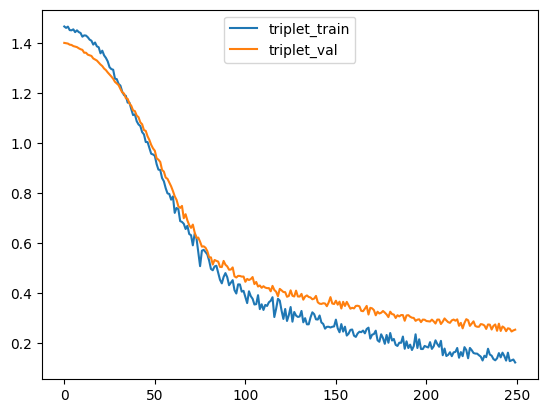

In [17]:
import matplotlib.pyplot as plt
plt.plot(triplet_train_losses, label="triplet_train")
plt.plot(triplet_val_losses, label="triplet_val")
leg = plt.legend(loc='upper center')
plt.show()

In [34]:
# import matplotlib.pyplot as plt
# plt.plot(tuplet_train_losses, label="tuplet_train")
# plt.plot(tuplet_val_losses, label="tuplet_val")
# leg = plt.legend(loc='upper center')
# plt.show()

In [19]:
anchor_0, pos_0, neg_0 = next(iter(triplet_test_loader))
# pos_2, labels = next(iter(tuplet_test_loader))

In [20]:
anchor = triplet_net.sim_model(anchor_0.cuda())
pos = triplet_net.sim_model(pos_0.cuda())
neg = triplet_net.sim_model(neg_0.cuda())

# pos_2 = tuplet_net.sim_model(pos_2.cuda())

In [21]:
print(triplet_net.triplet_loss_fn(anchor, pos, neg))
# print(tuplet_net.tuplet_loss_fn(pos_2, labels.squeeze()))

tensor(0.2521, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(0.6849, device='cuda:0', grad_fn=<MeanBackward0>)


In [22]:
triplet_train_loader = DataLoader(triplet_dataset, shuffle=True, batch_size=len(train_triplet_df))
_, triplet_train_pos, triplet_train_neg = next(iter(triplet_train_loader))

# tuplet_train_loader = DataLoader(tuplet_dataset, shuffle=True, batch_size=len(train_tuplet_df))
# tuplet_train_pos, _ = next(iter(tuplet_train_loader))

In [23]:
def get_embeddings(model, masks):
    return model(masks)

In [24]:
triplet_train_pos_embeddings = get_embeddings(triplet_net.sim_model, triplet_train_pos.cuda()).cpu().detach().type(torch.float16)
triplet_train_neg_embeddings = get_embeddings(triplet_net.sim_model, triplet_train_neg.cuda()).cpu().detach().type(torch.float16)

# tuplet_train_pos_embeddings = get_embeddings(tuplet_net.sim_model, tuplet_train_pos.cuda()).cpu().detach().type(torch.float16)
# tuplet_train_neg_embeddings = get_embeddings(tuplet_net.sim_model, triplet_train_neg.cuda()).cpu().detach().type(torch.float16)


In [25]:
from scipy.spatial.distance import cdist

In [26]:
distance_modes=["euclidean",
               'minkowski',
               'cityblock',
               'sqeuclidean',
               'correlation',
               'chebyshev',
               'canberra',
               'braycurtis',
               'dice']

In [27]:
def distance(x,y,mode="euclidean"):
    return cdist(x,y, mode).sum()/y.shape[0]

In [28]:
results = []
for mode in distance_modes:
    tp = fn = 0
    pos_paths=list(set(test_triplet_df["pos"]))
    for i in range(len(pos_paths)):
        mask = torch.Tensor(np.load(pos_paths[i], allow_pickle=True)).view(1,1,image_dim,image_dim)
        mask_emb = triplet_net.sim_model(mask.cuda()).cpu().detach().type(torch.float16)
        pos_distance = distance(mask_emb, triplet_train_pos_embeddings)
        neg_distance = distance(mask_emb, triplet_train_neg_embeddings)
        if pos_distance<neg_distance:
            tp+=1
        else:
            fn+=1
            
    tn = fp = 0
    neg_paths=list(set(test_triplet_df["neg"]))
    for i in range(len(neg_paths)):
        mask = torch.Tensor(np.load(neg_paths[i], allow_pickle=True)).view(1,1,image_dim,image_dim)
        mask_emb = triplet_net.sim_model(mask.cuda()).cpu().detach().type(torch.float16)
        pos_distance = distance(mask_emb, triplet_train_pos_embeddings)
        neg_distance = distance(mask_emb, triplet_train_neg_embeddings)
        if pos_distance>neg_distance:
            tn+=1
        else:
            fp+=1

    results.append({"mode":mode,
                    "tp":tp,
                    "fp":fp,
                    "tn":tn,
                    "fn":fn})

In [29]:
print("triplet")
from tabulate import tabulate
headers = ["mode", "tp", "fp", "tn", "fn"]
for result in results:
    print(tabulate(result.items(), headers = headers))

triplet
mode    tp
------  ---------
mode    euclidean
tp      5
fp      8
tn      69
fn      24
mode    tp
------  ---------
mode    minkowski
tp      5
fp      8
tn      69
fn      24
mode    tp
------  ---------
mode    cityblock
tp      5
fp      8
tn      69
fn      24
mode    tp
------  -----------
mode    sqeuclidean
tp      5
fp      8
tn      69
fn      24
mode    tp
------  -----------
mode    correlation
tp      5
fp      8
tn      69
fn      24
mode    tp
------  ---------
mode    chebyshev
tp      5
fp      8
tn      69
fn      24
mode    tp
------  --------
mode    canberra
tp      5
fp      8
tn      69
fn      24
mode    tp
------  ----------
mode    braycurtis
tp      5
fp      8
tn      69
fn      24
mode    tp
------  ----
mode    dice
tp      5
fp      8
tn      69
fn      24


In [35]:
# results = []
# for mode in distance_modes:
#     tp = fn = 0
#     pos_paths=list(set(test_triplet_df["pos"]))
#     for i in range(len(pos_paths)):
#         mask = torch.Tensor(np.load(pos_paths[i], allow_pickle=True)).view(1,1,image_dim,image_dim)
#         mask_emb = tuplet_net.sim_model(mask.cuda()).cpu().detach().type(torch.float16)
#         pos_distance = distance(mask_emb, tuplet_train_pos_embeddings)
#         neg_distance = distance(mask_emb, tuplet_train_neg_embeddings)
#         if pos_distance<neg_distance:
#             tp+=1
#         else:
#             fn+=1
            
#     tn = fp = 0
#     neg_paths=list(set(test_triplet_df["neg"]))
#     for i in range(len(neg_paths)):
#         mask = torch.Tensor(np.load(neg_paths[i], allow_pickle=True)).view(1,1,image_dim,image_dim)
#         mask_emb = tuplet_net.sim_model(mask.cuda()).cpu().detach().type(torch.float16)
#         pos_distance = distance(mask_emb, tuplet_train_pos_embeddings)
#         neg_distance = distance(mask_emb, tuplet_train_neg_embeddings)
#         if pos_distance>neg_distance:
#             tn+=1
#         else:
#             fp+=1

#     results.append({"mode":mode,
#                     "tp":tp,
#                     "fp":fp,
#                     "tn":tn,
#                     "fn":fn})

In [36]:
# print("tuplet")
# from tabulate import tabulate
# headers = ["mode", "tp", "fp", "tn", "fn"]
# for result in results:
#     print(tabulate(result.items(), headers = headers))

In [32]:
get_similarity(anchor_0[0].cpu().detach(), pos_0[0].cpu().detach()).squeeze()

tensor(0.5766)

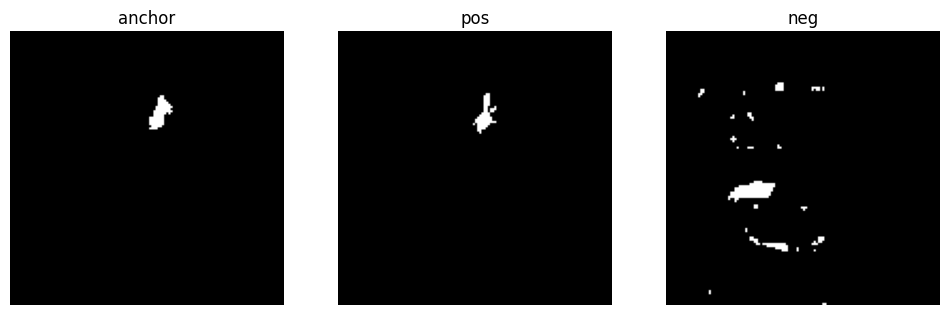

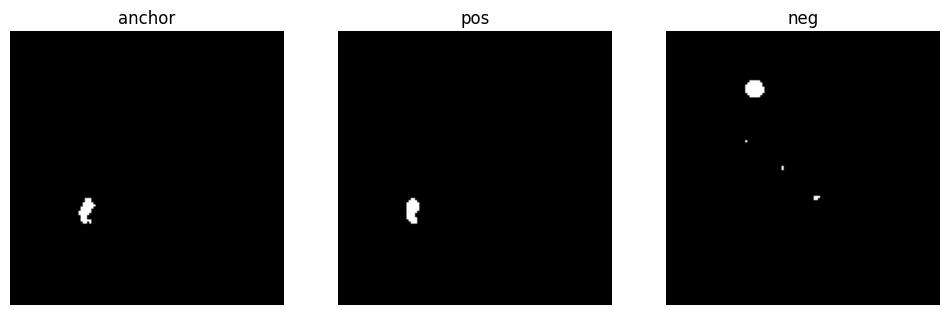

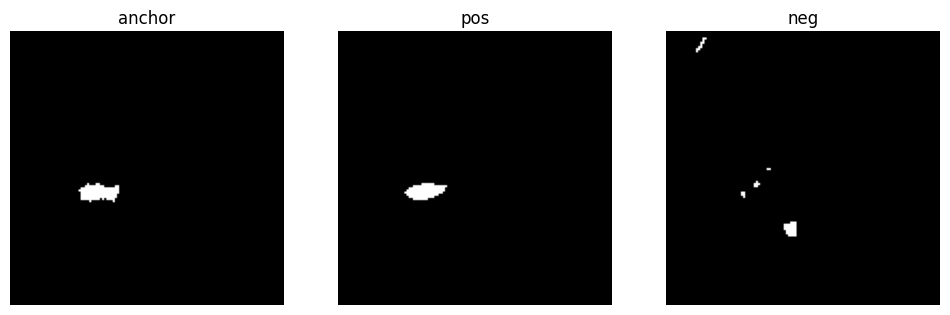

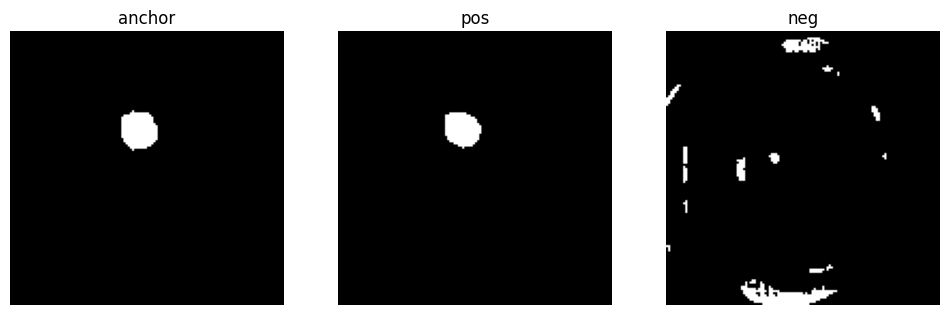

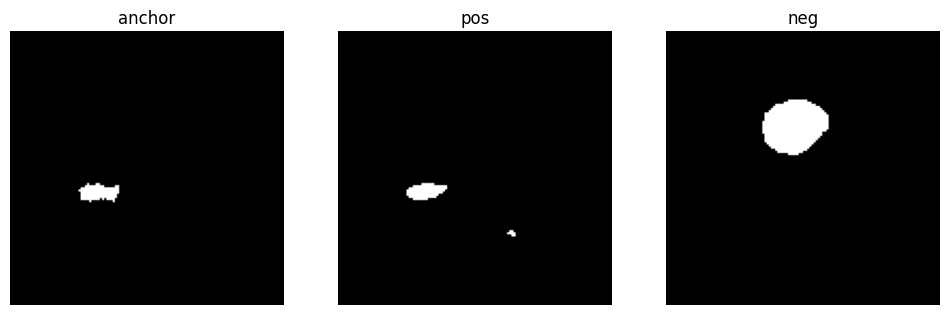

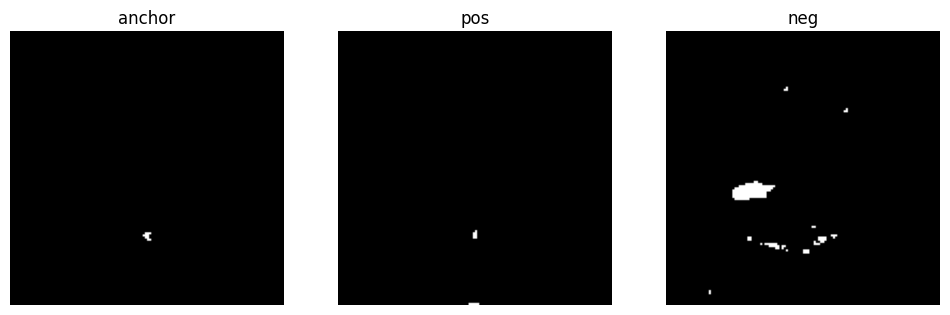

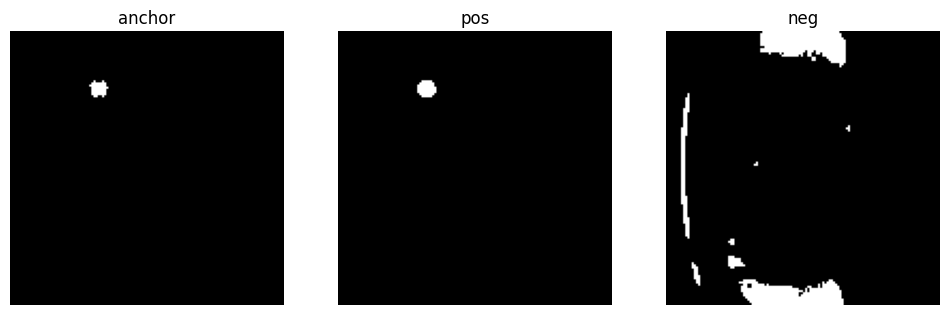

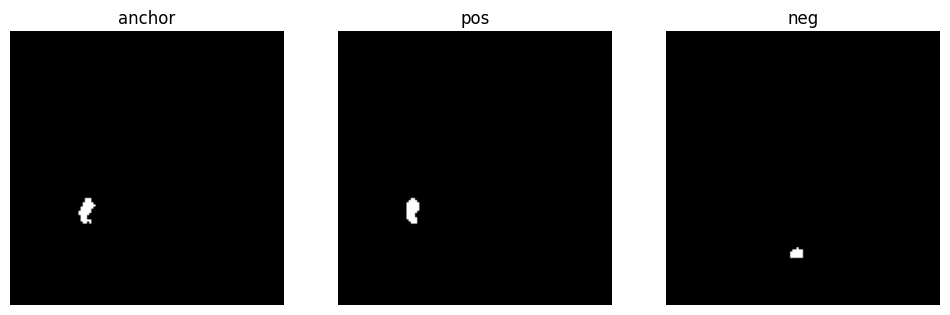

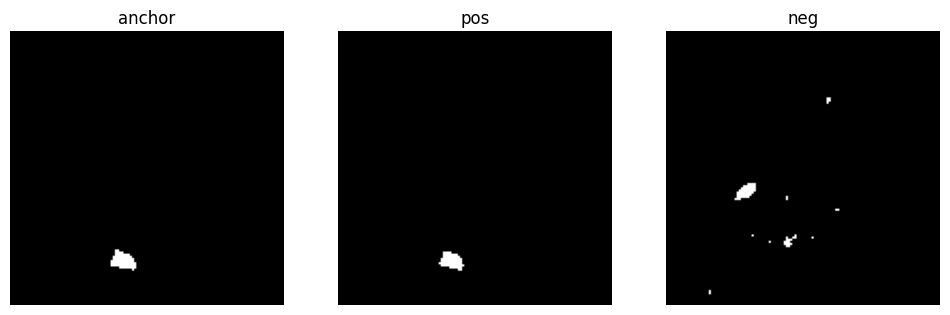

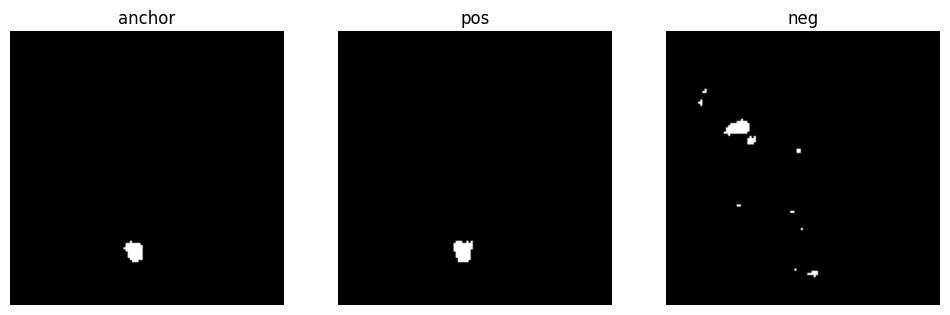

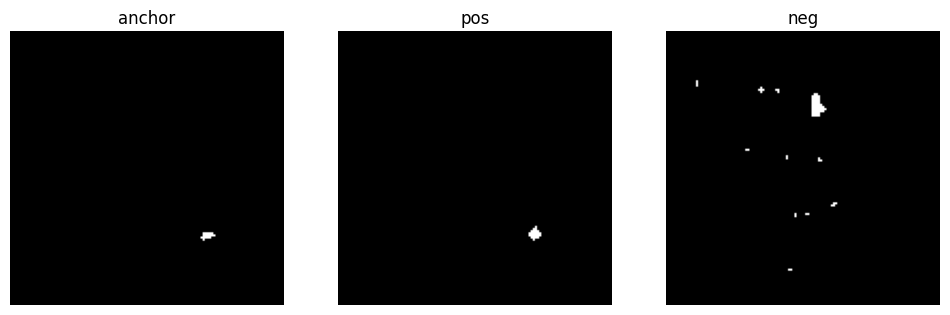

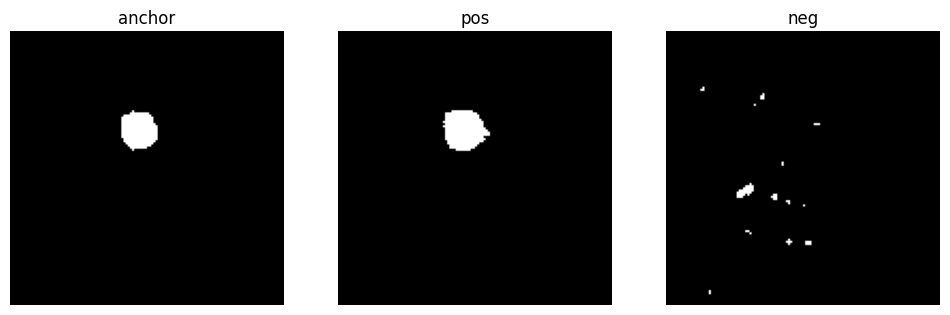

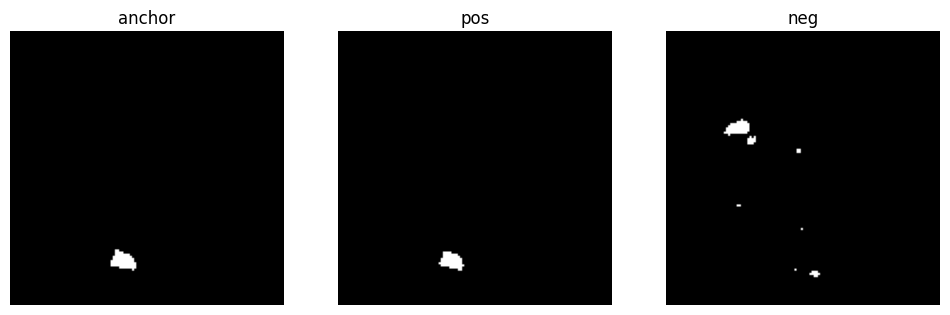

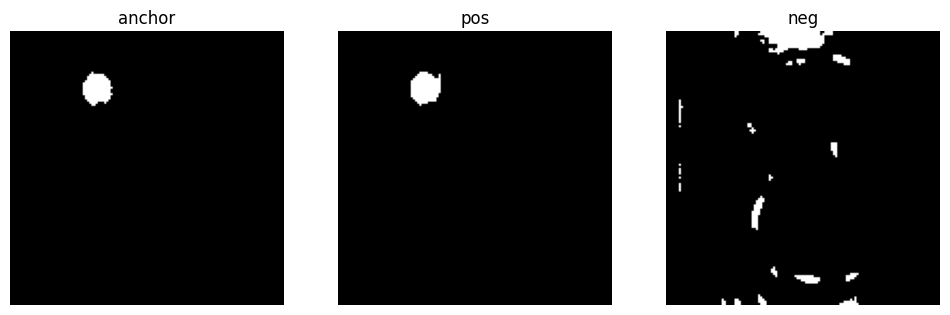

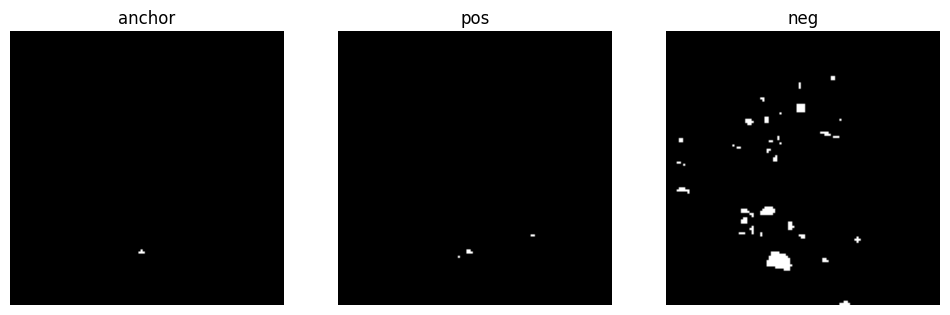

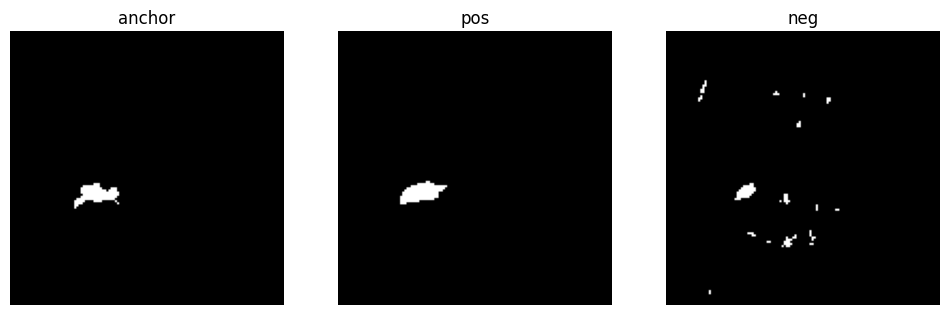

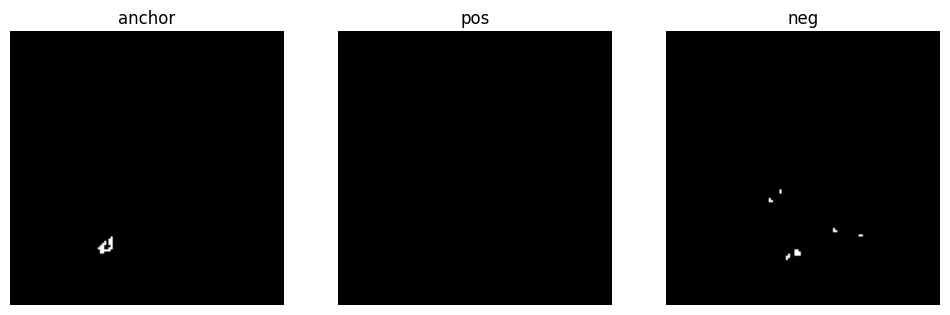

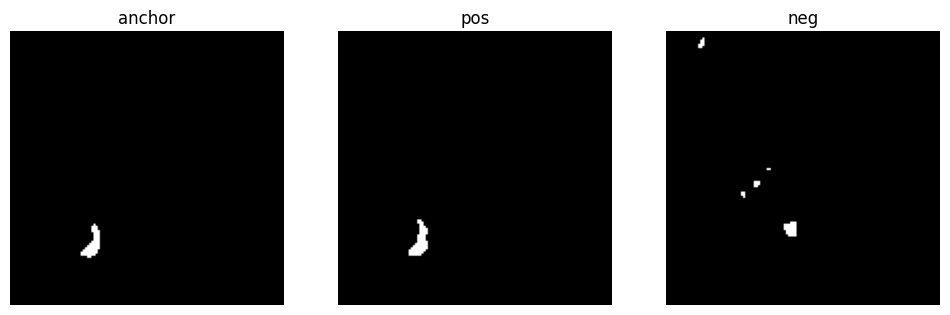

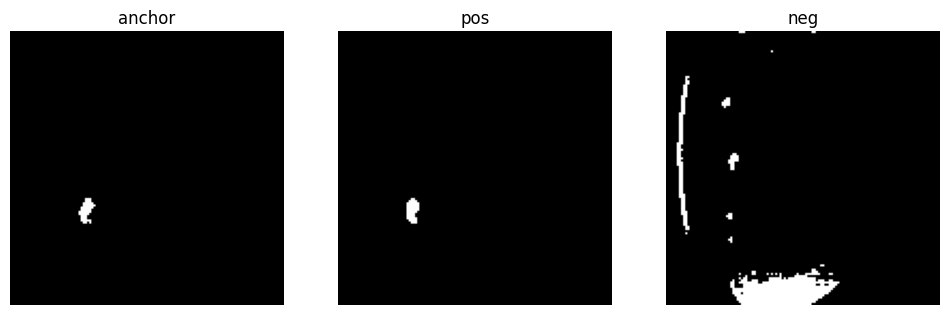

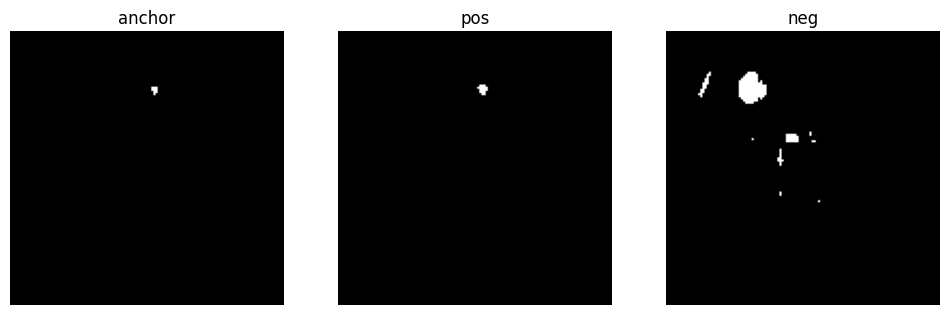

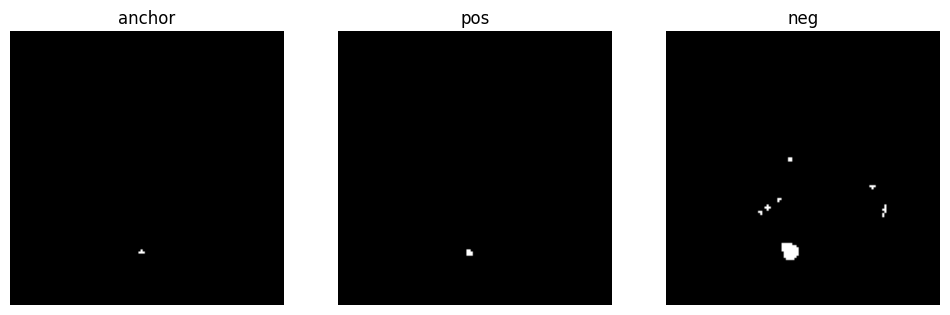

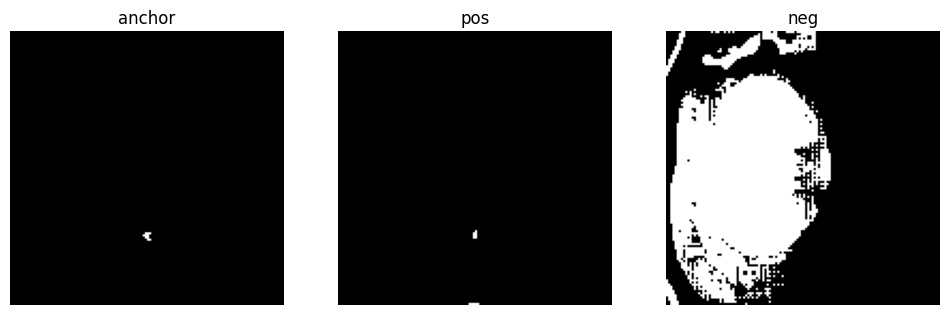

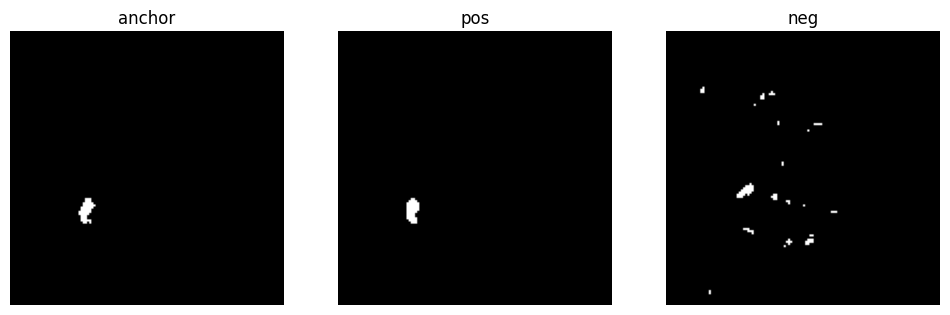

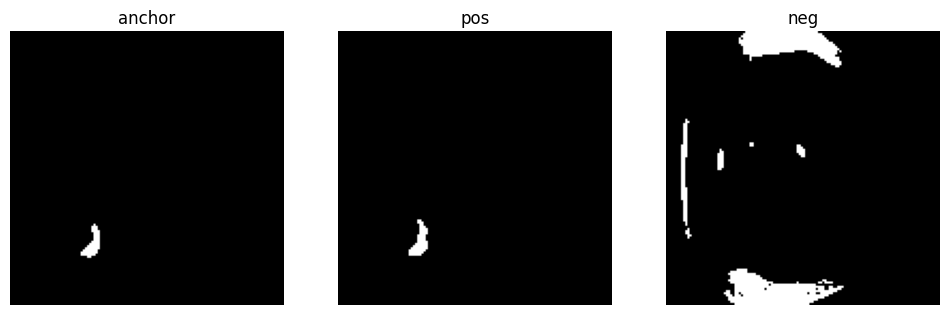

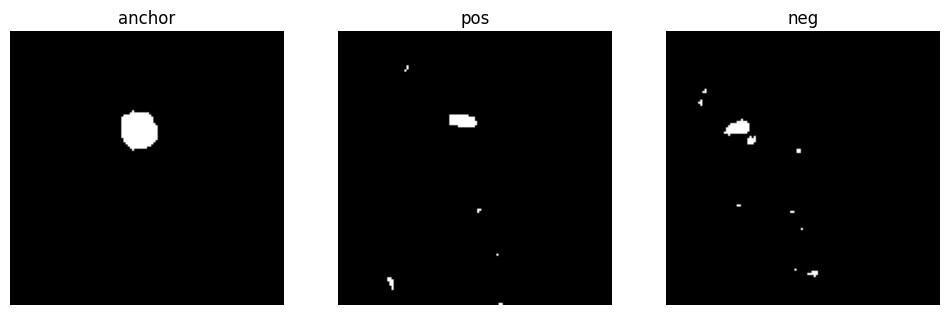

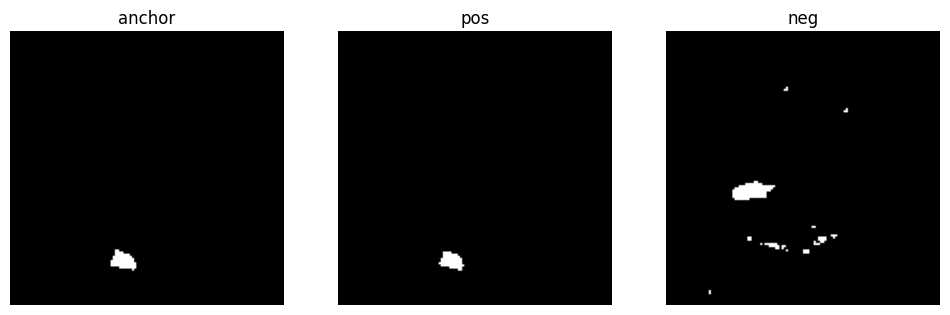

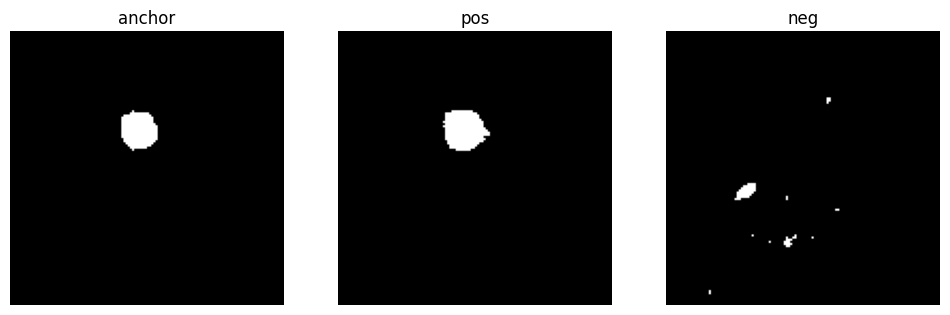

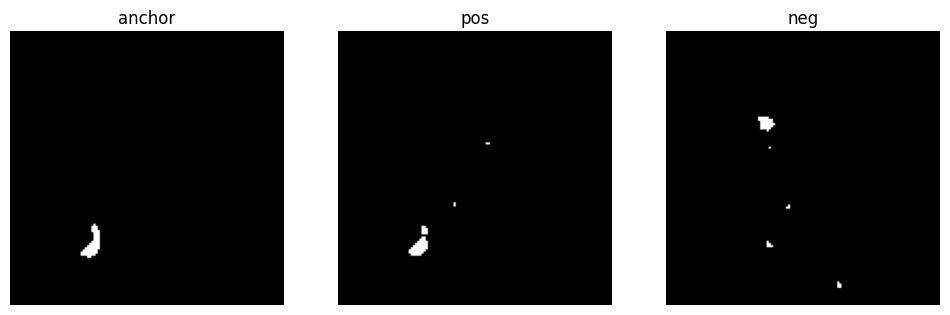

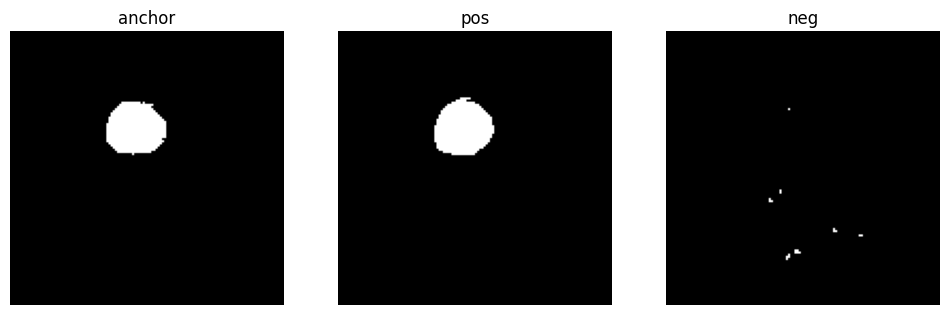

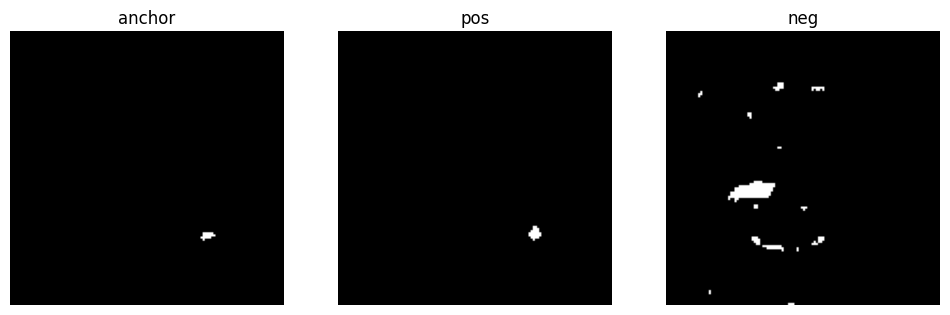

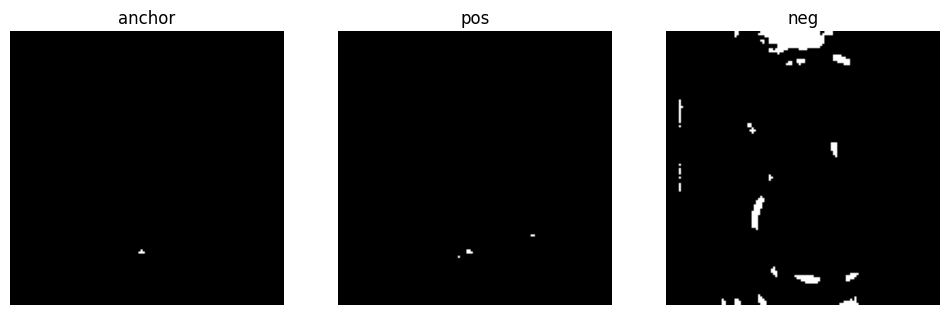

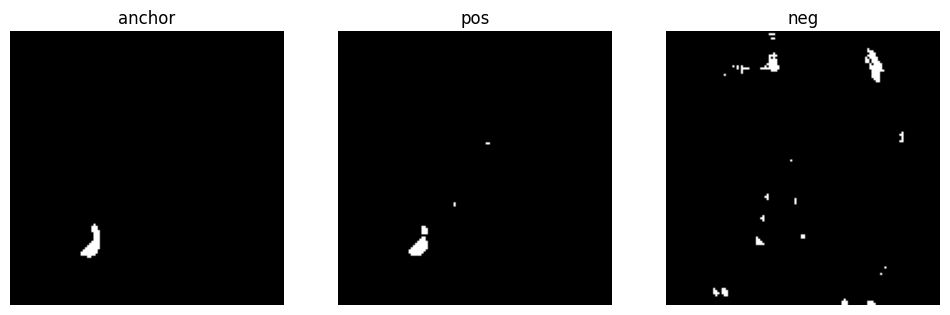

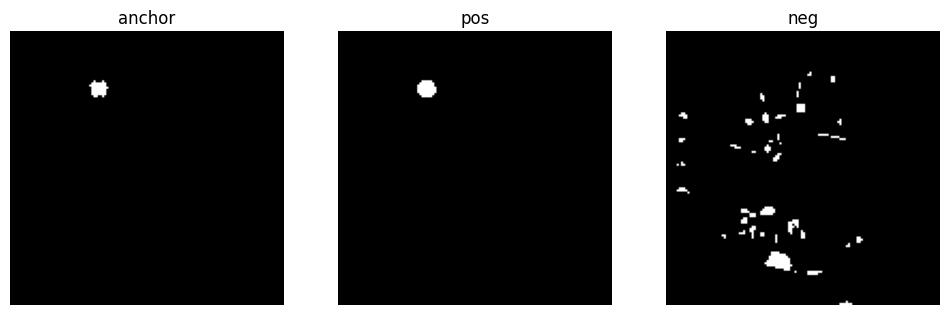

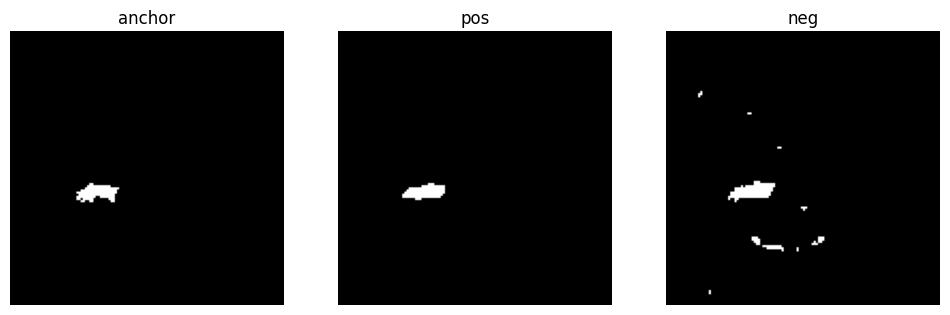

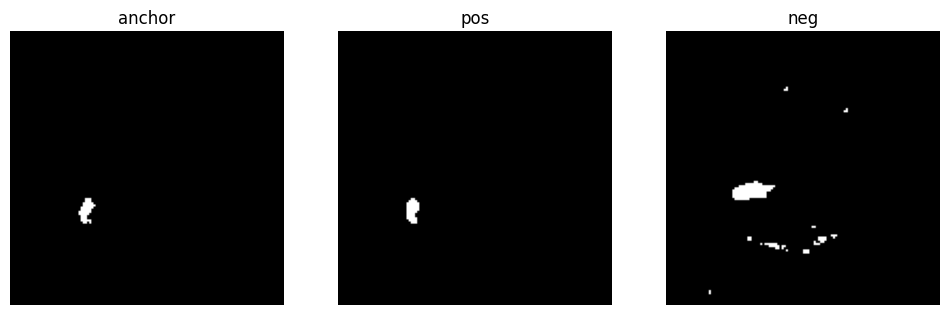

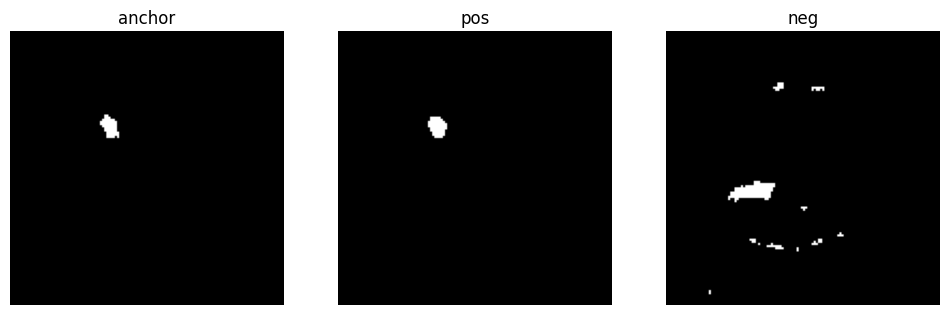

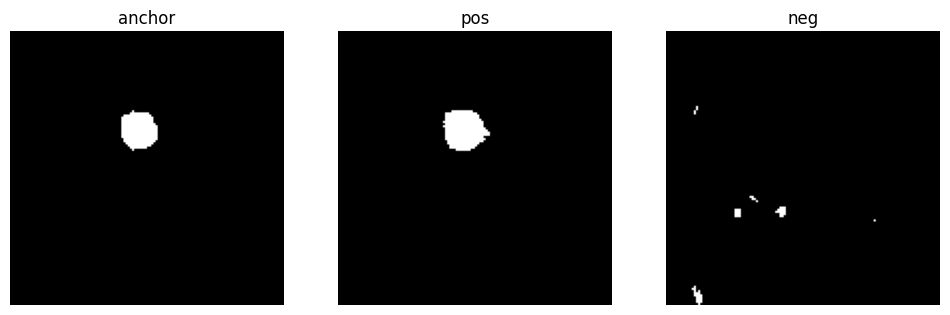

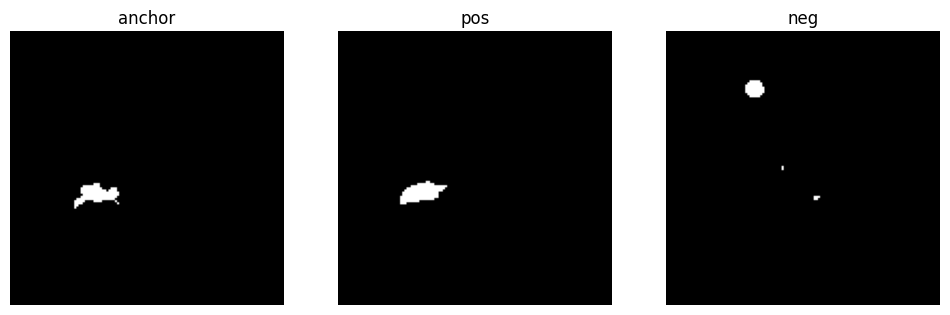

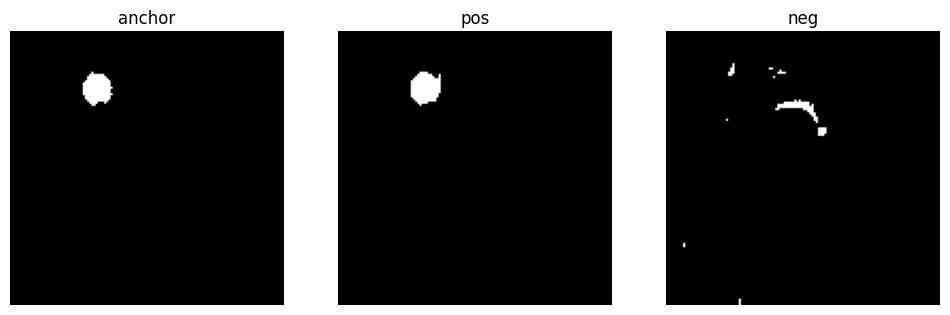

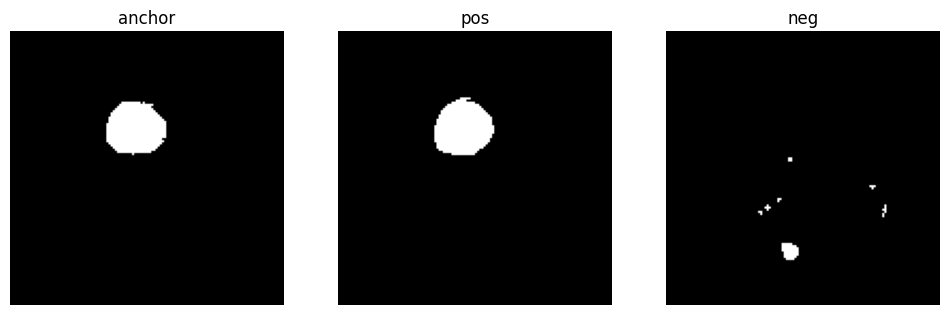

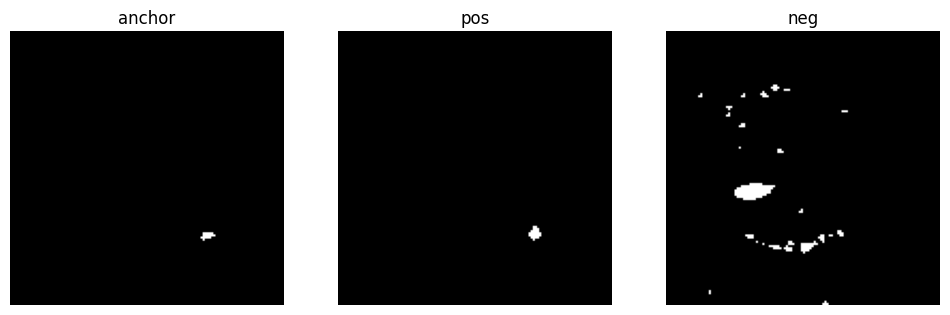

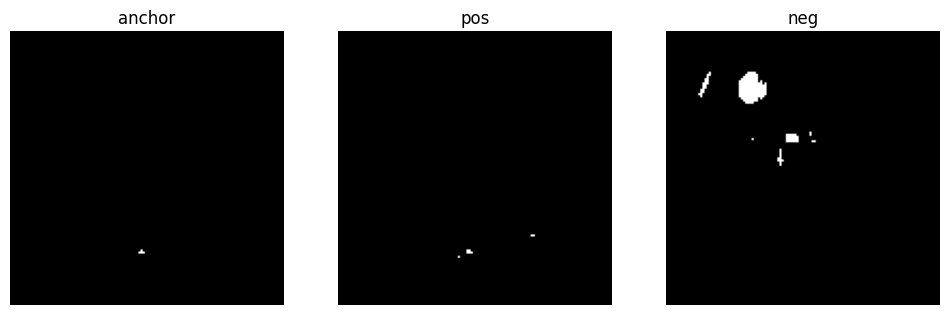

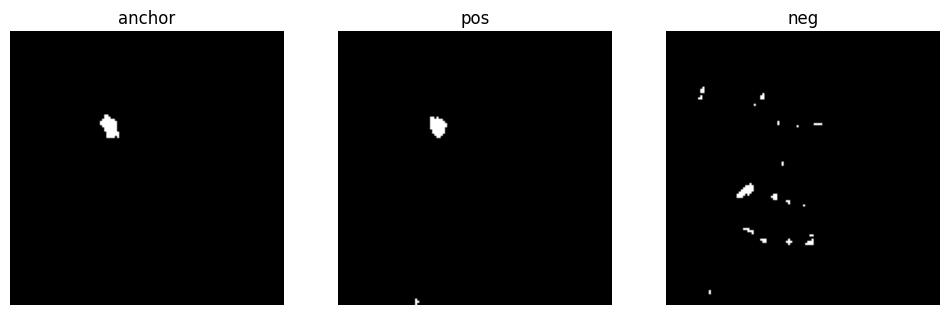

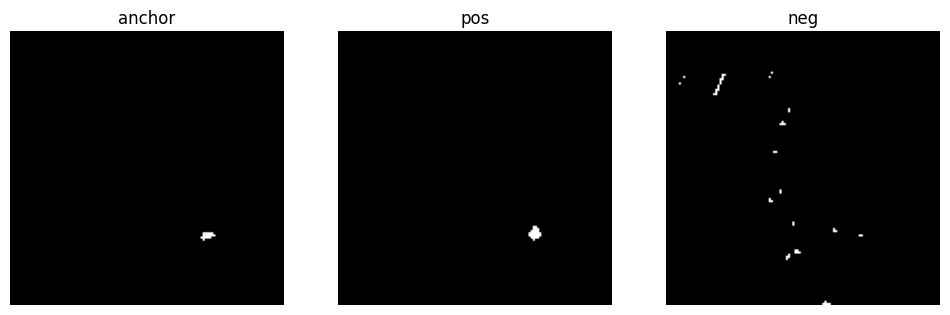

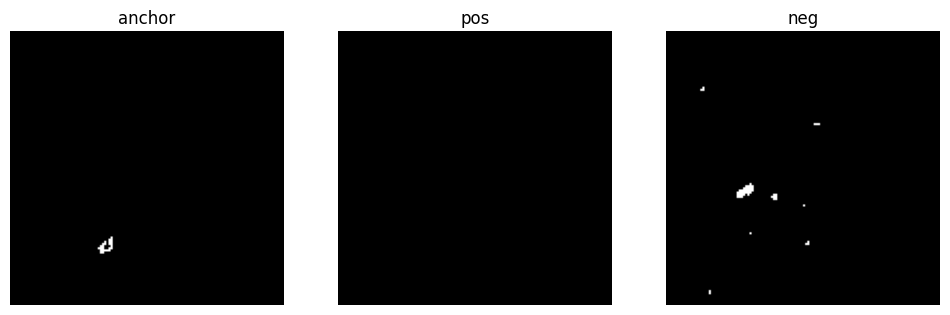

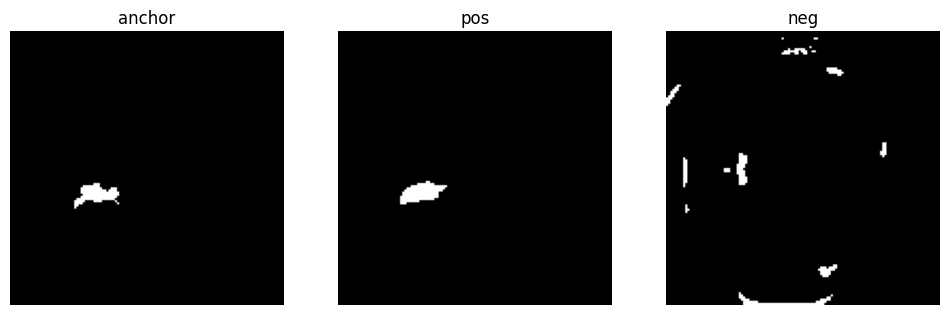

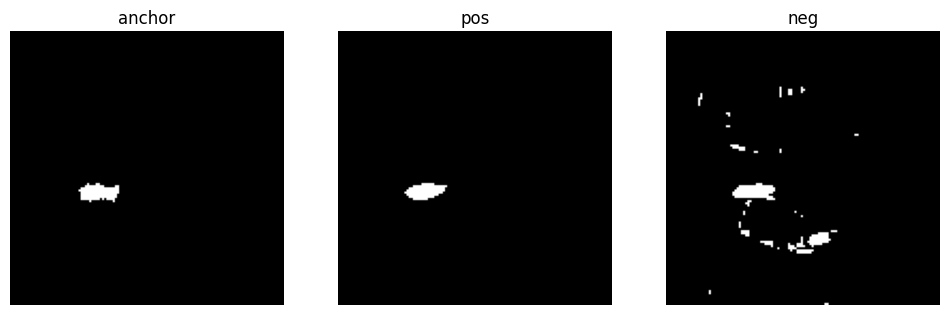

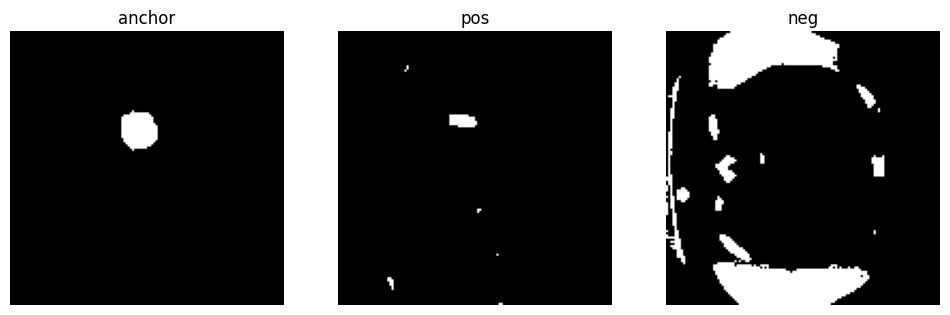

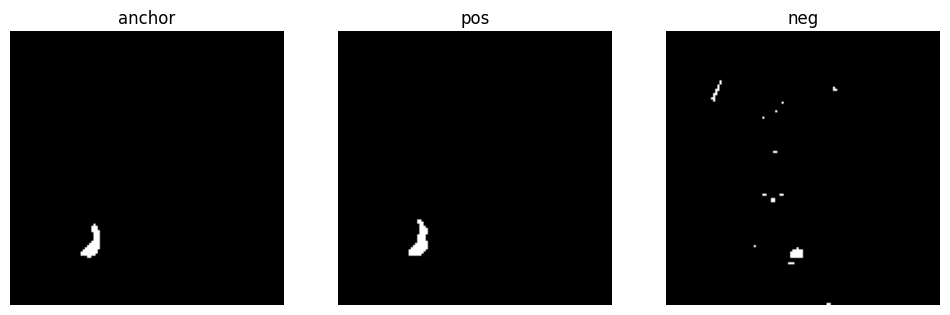

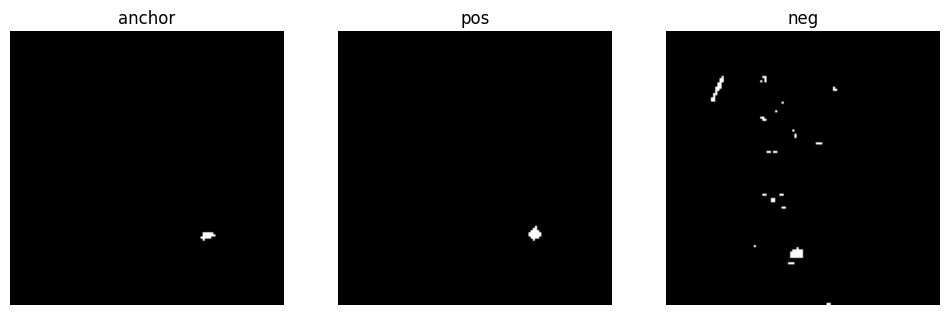

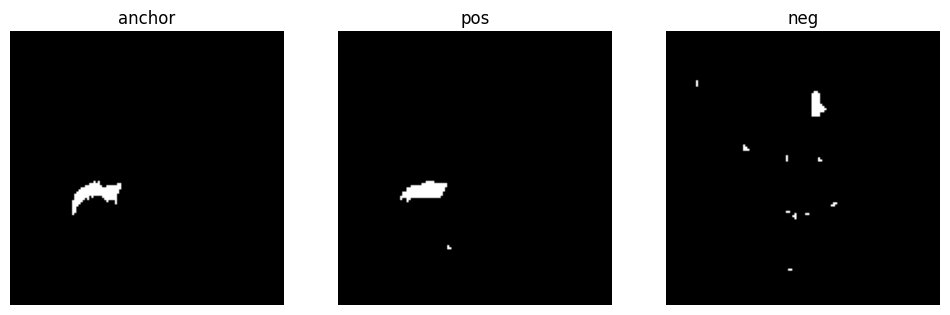

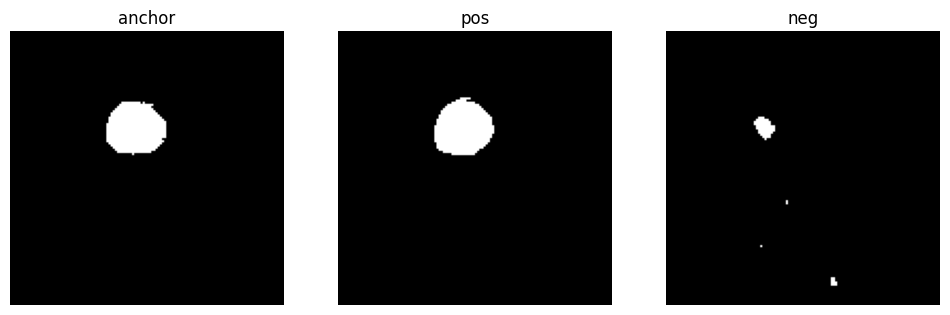

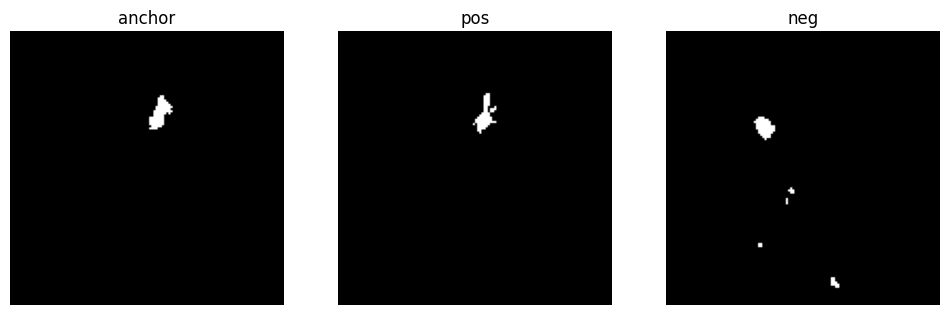

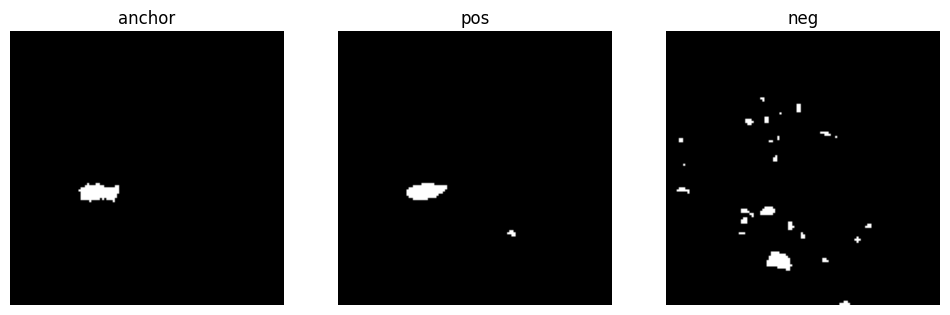

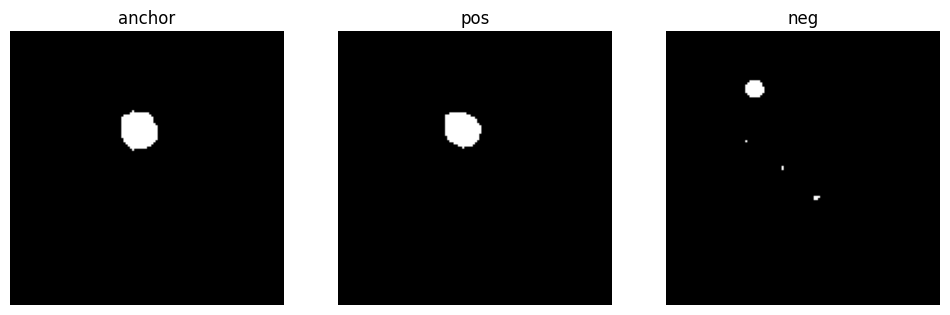

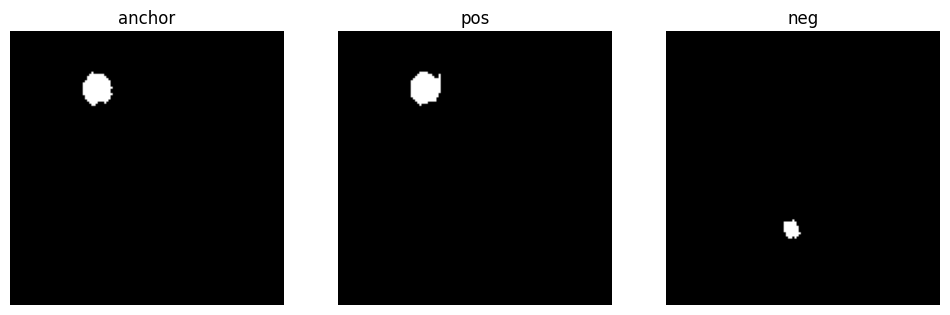

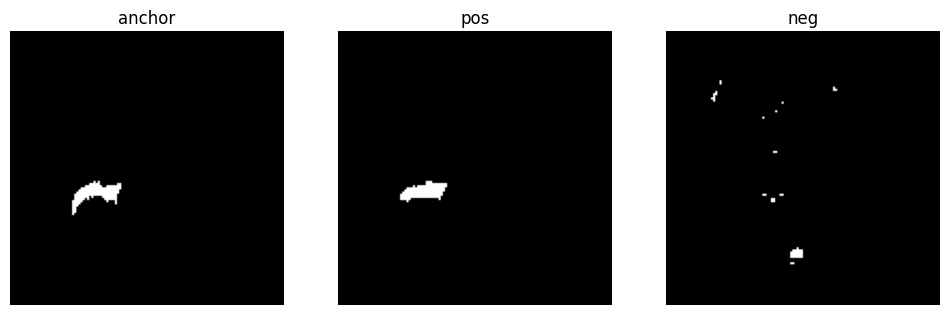

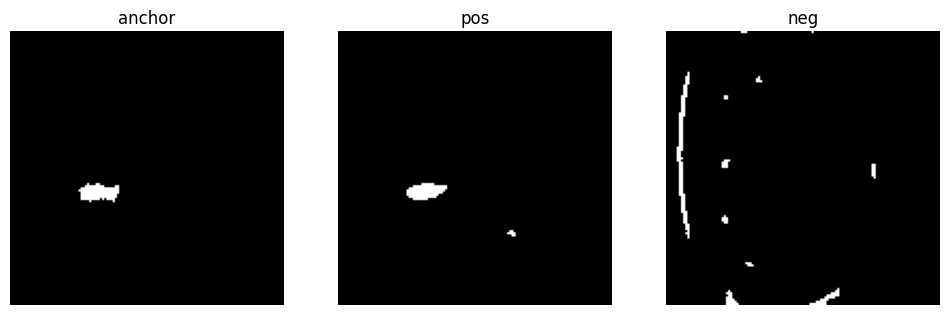

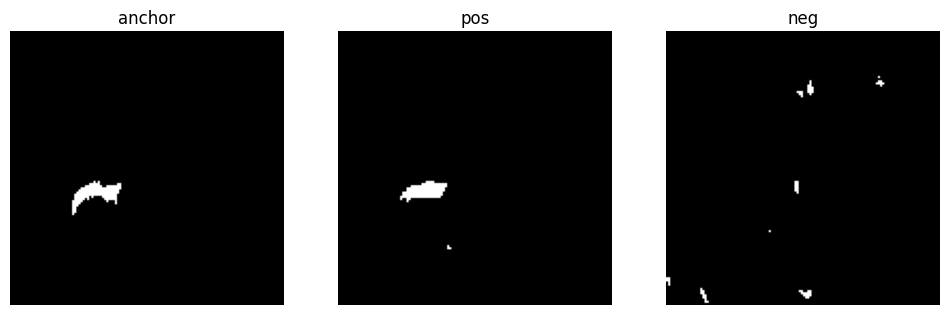

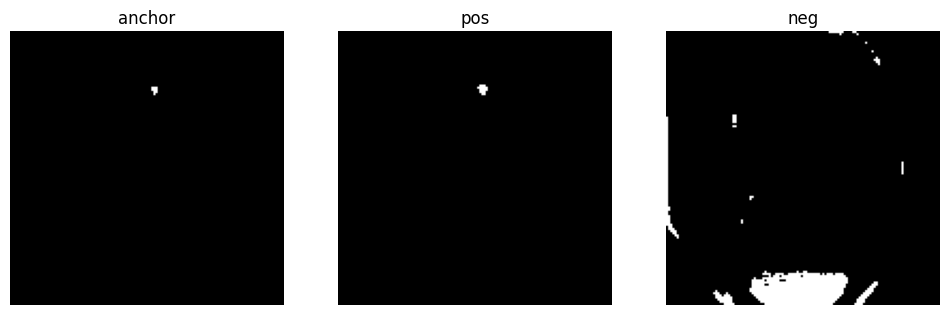

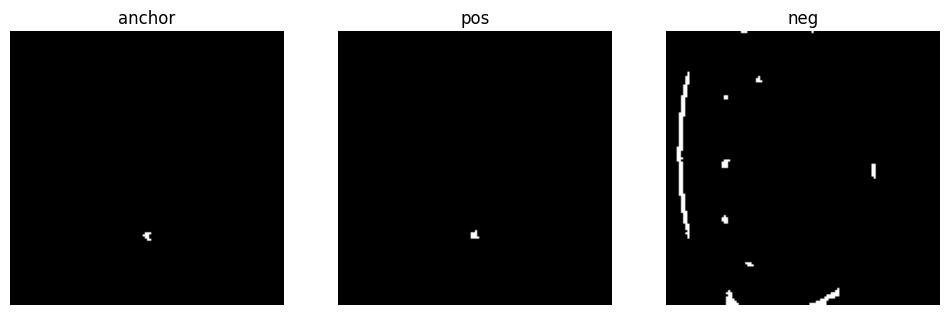

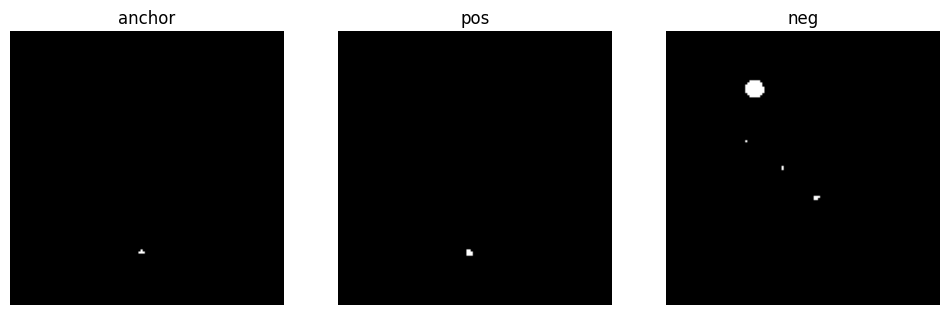

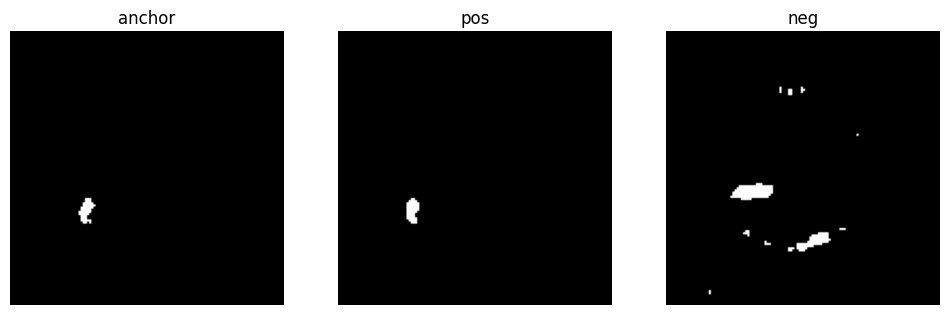

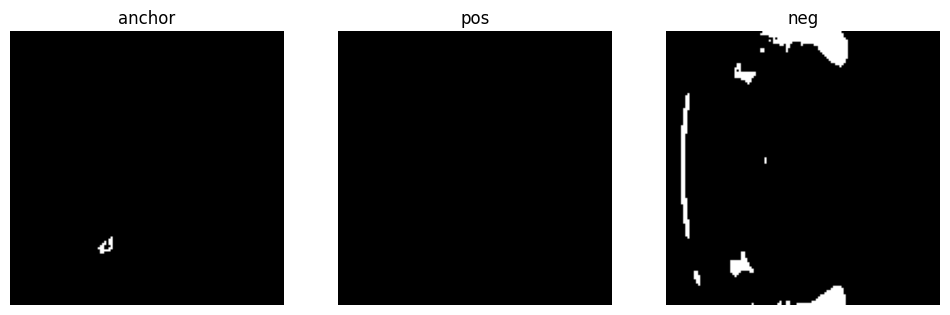

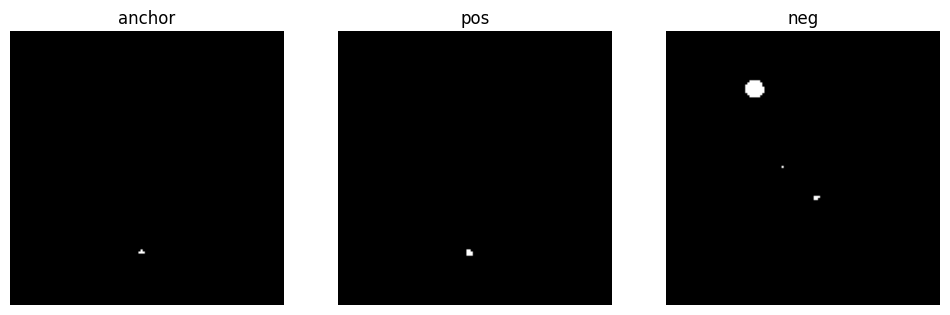

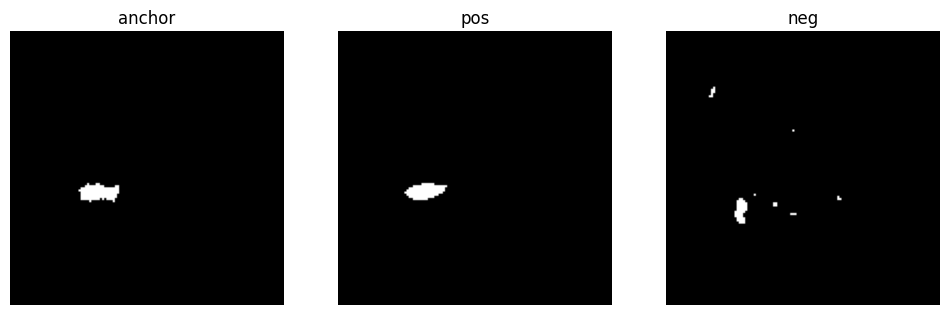

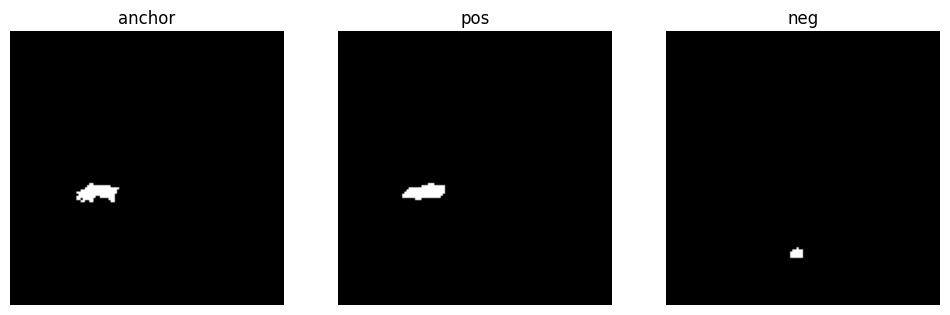

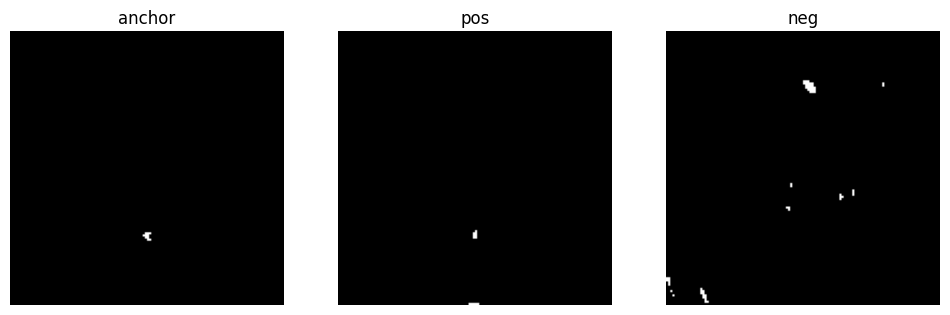

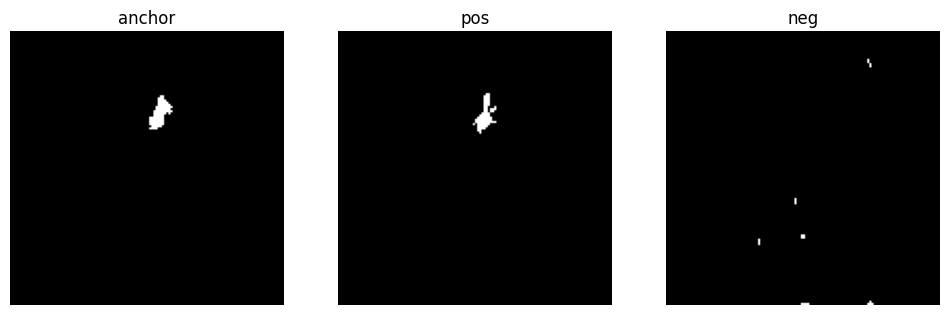

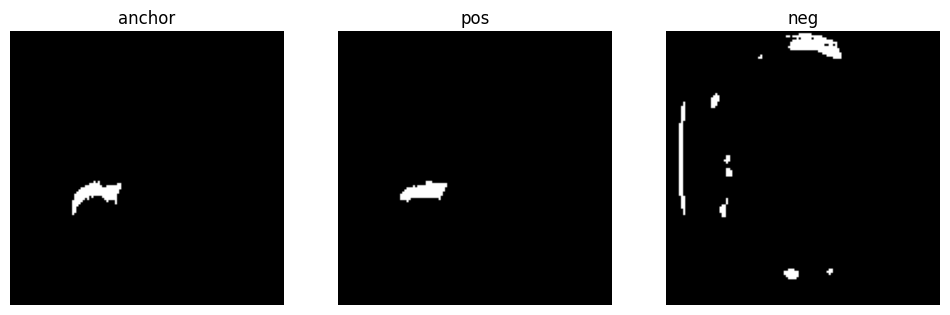

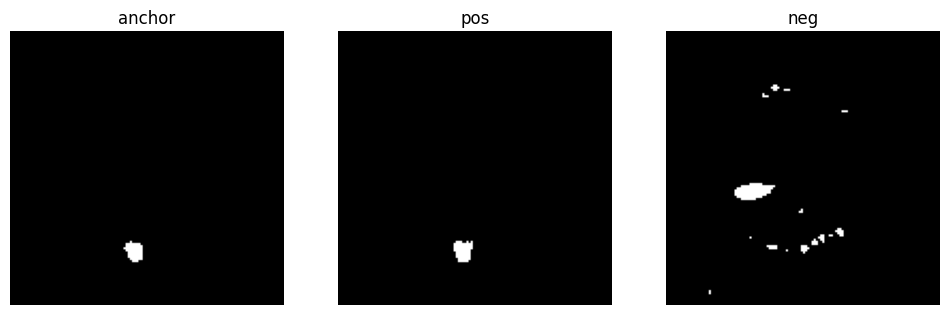

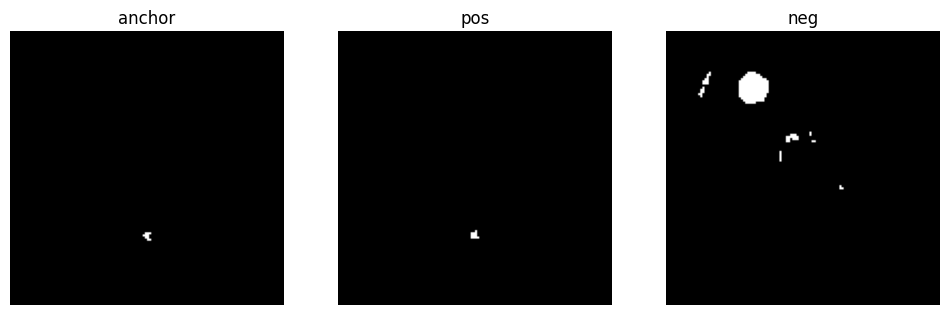

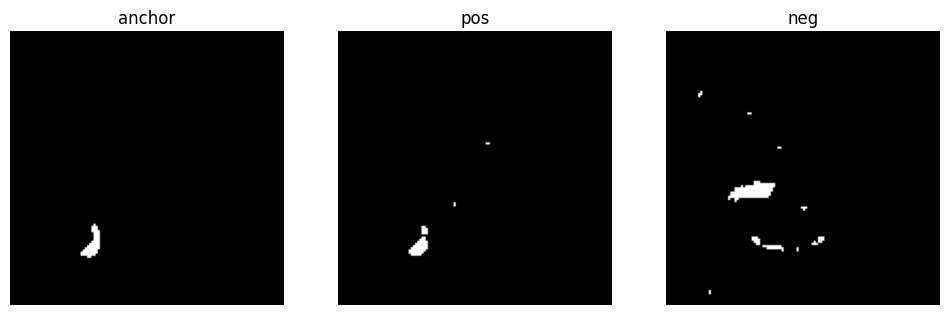

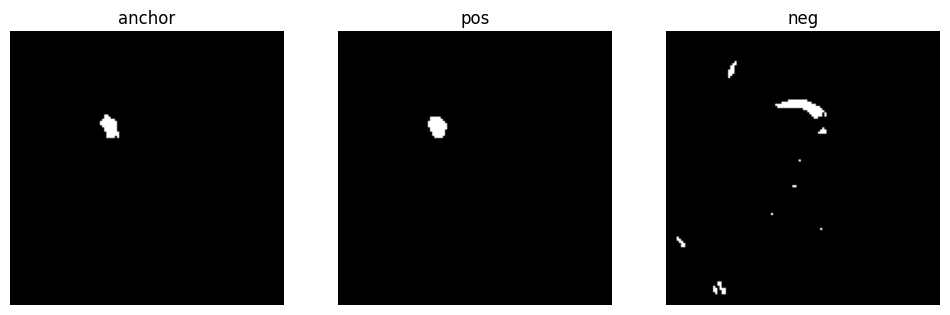

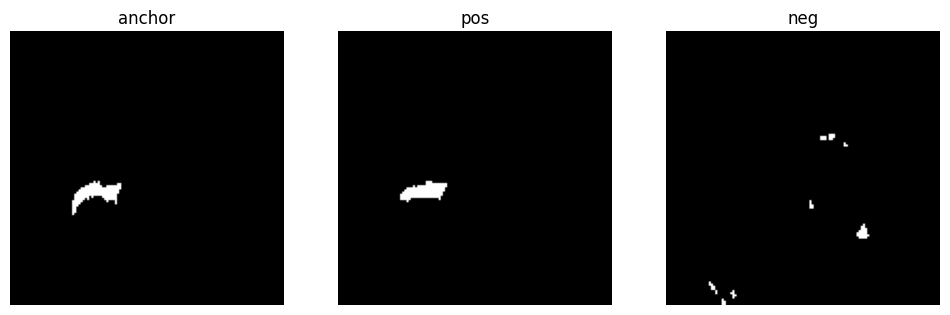

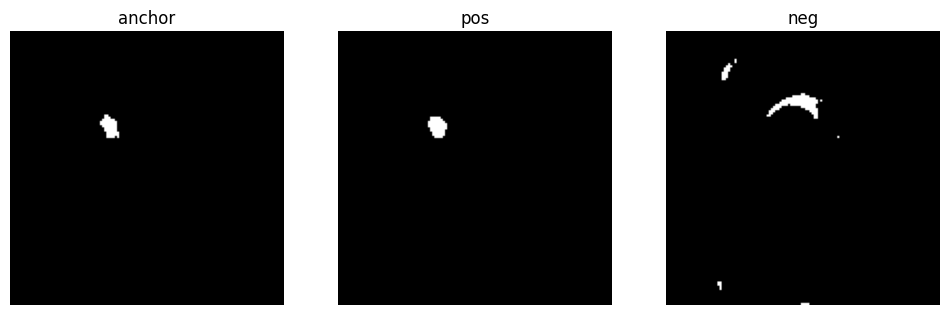

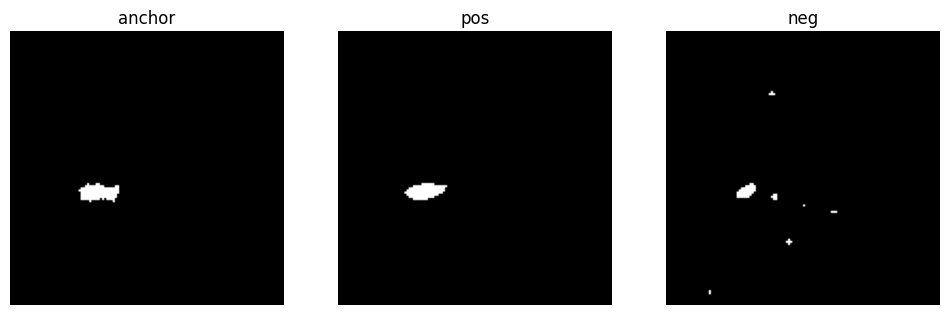

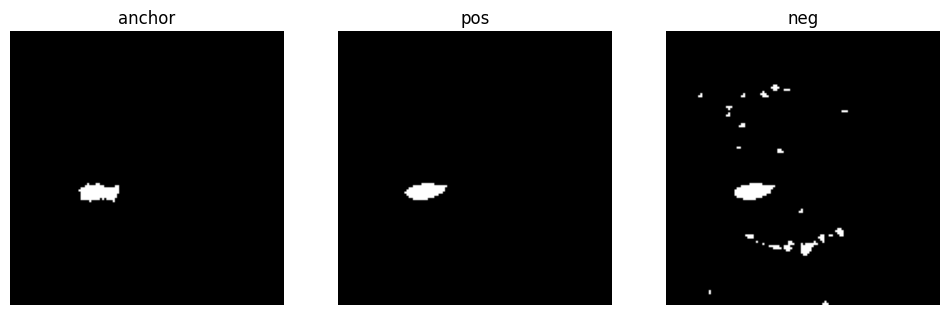

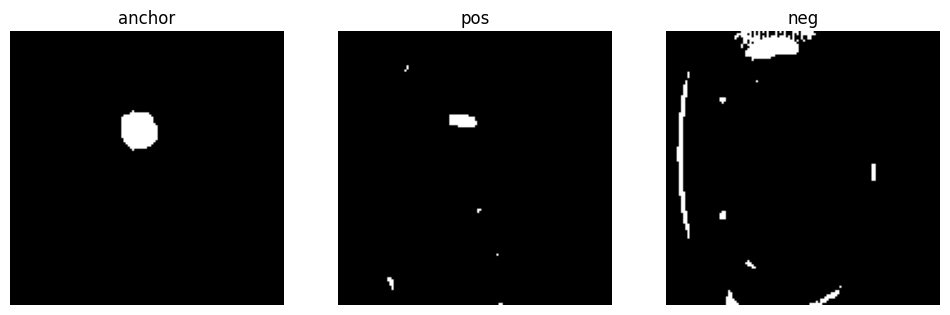

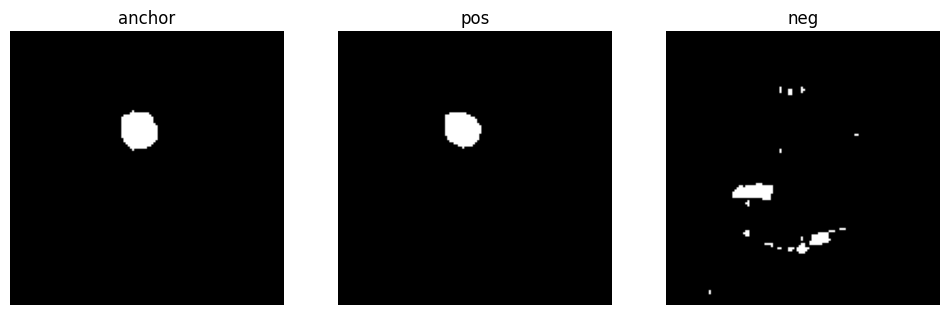

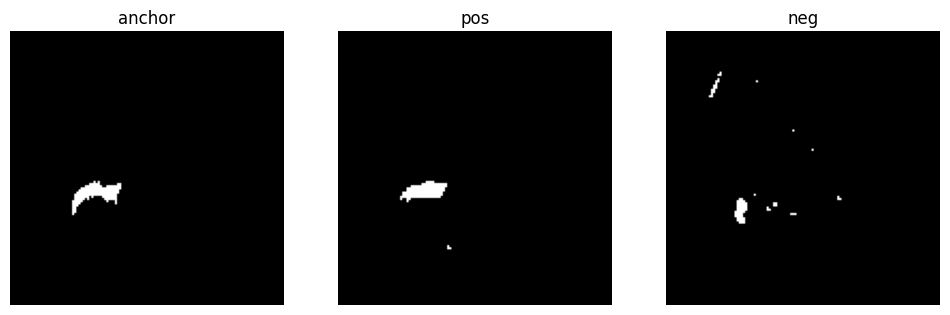

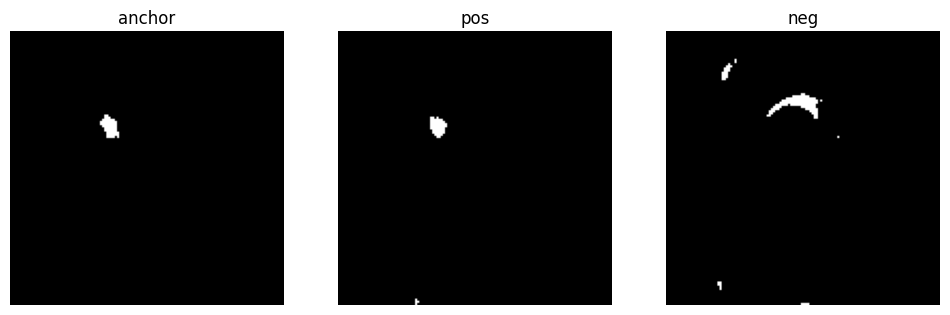

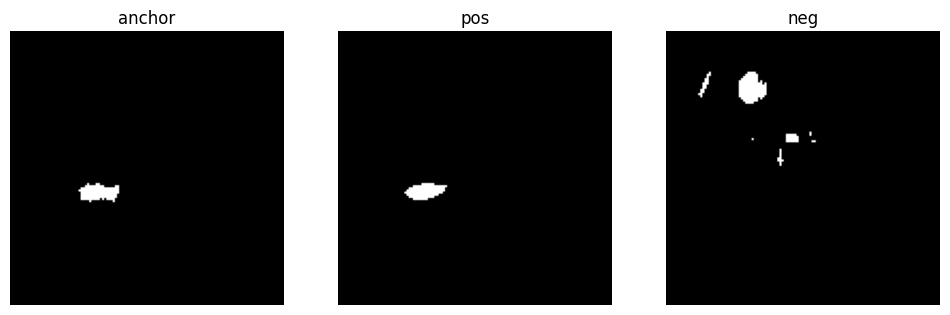

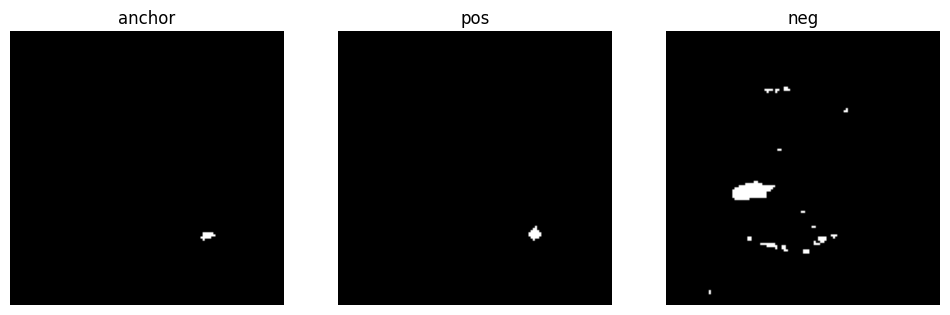

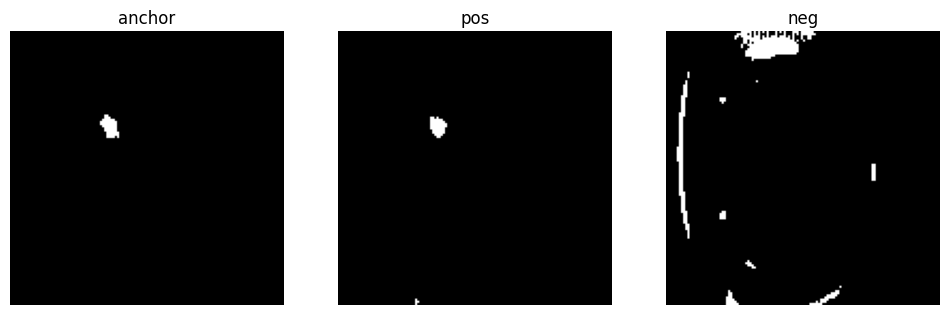

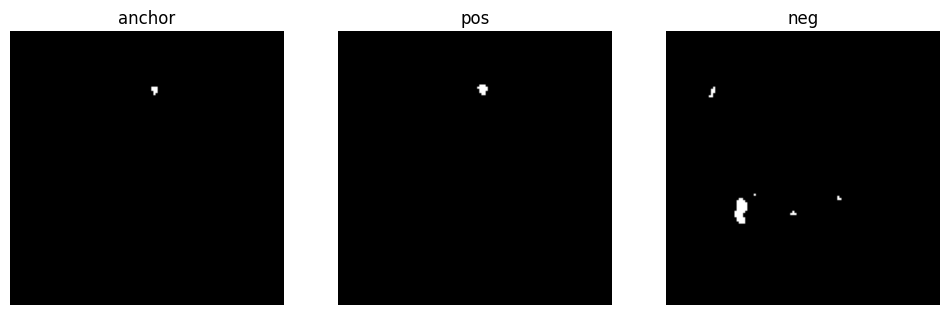

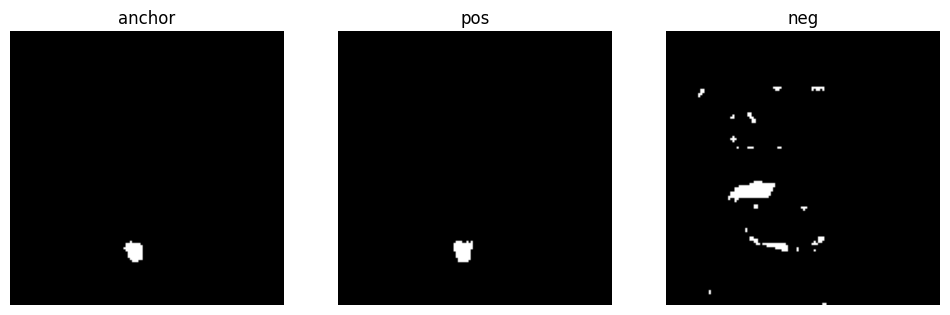

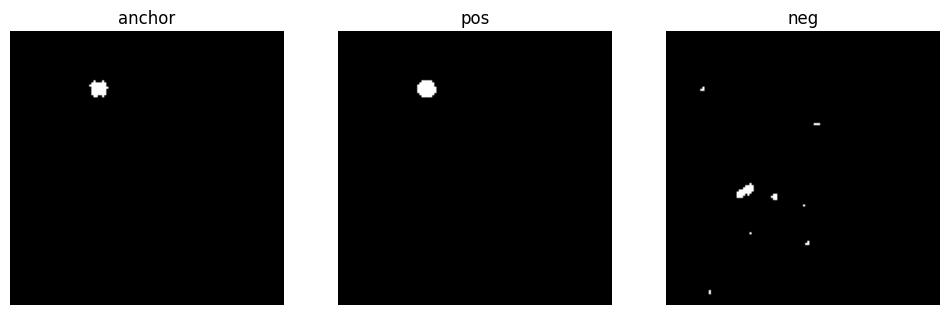

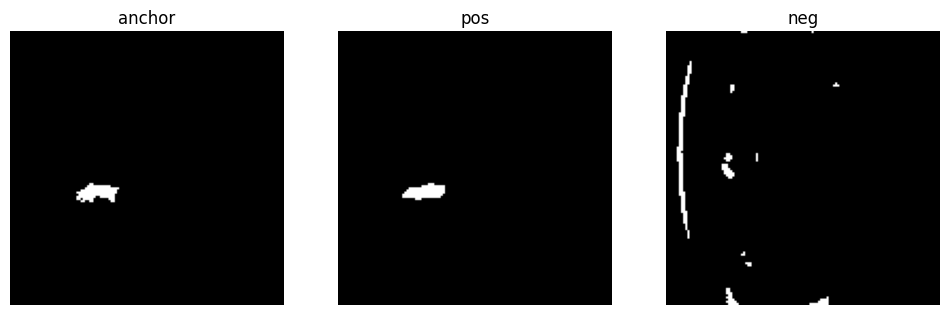

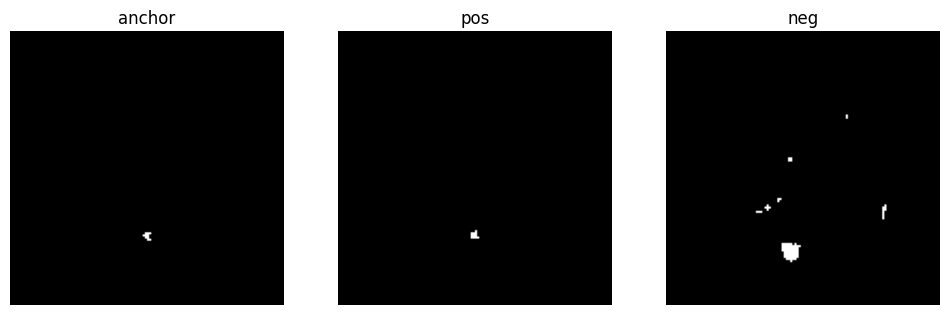

IndexError: index 90 is out of bounds for dimension 0 with size 90

In [33]:
idx = 0
for i in range(idx, idx+190):
    # pos_sim = get_similarity(anchor_0[0].cpu().detach(), pos_0[0].cpu().detach()).squeeze()
    neg_sim = get_similarity(anchor_0[0].cpu().detach(), neg_0[0].cpu().detach()).squeeze()
    # if pos_sim<=0.7:
    #     print("wrong_pos", i)
    # if neg_sim>0.5:
    #     print("wrong_neg", i)
    sv.plot_images_grid(
        images=[anchor_0[i][0].cpu().detach().numpy(), pos_0[i][0].cpu().detach().numpy(), neg_0[i][0].cpu().detach().numpy()],
        grid_size=(1,3),
        titles=["anchor", "pos", "neg"]
    )